In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import xgboost

In [2]:
url = 'https://raw.githubusercontent.com/IvanVC21/Examen-AI-Lab-School/main/Parte1/diamonds.csv'

In [3]:
df = pd.read_csv(url)
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## Exploratory Data Analysis
Se realizara una inspeccion para determinar si se requiere hacer una limpieza y posteriormente se realizara un EDA para poder obtener insights del dataset que pueden ser utiles a la hora de la ingenieria/seleccion de caracteristicas.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [5]:
df = df.drop('Unnamed: 0', axis=1)

In [6]:
#Check special characters
for col in df.columns:
        if df[col].dtype == 'object':
            print(col)
            print(df[col].str.contains('[^a-zA-Z0-9_ ]').any())


cut
False
color
False
clarity
False


In [7]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


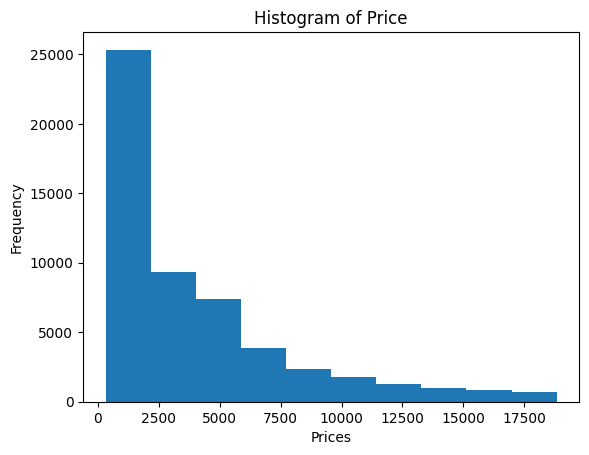

In [8]:
plt.hist(df['price'], bins=10)
plt.title('Histogram of Price')
plt.xlabel('Prices')
plt.ylabel('Frequency')
plt.show()

Podemos ver que como es de esperar, nuestro histograma esta cargado hacia la izquierda por lo que para efectos del modelo sera necesario aplicarle una transformacion, al menos para esta columna que vendria siendo nuestra Y (variable dependiente).

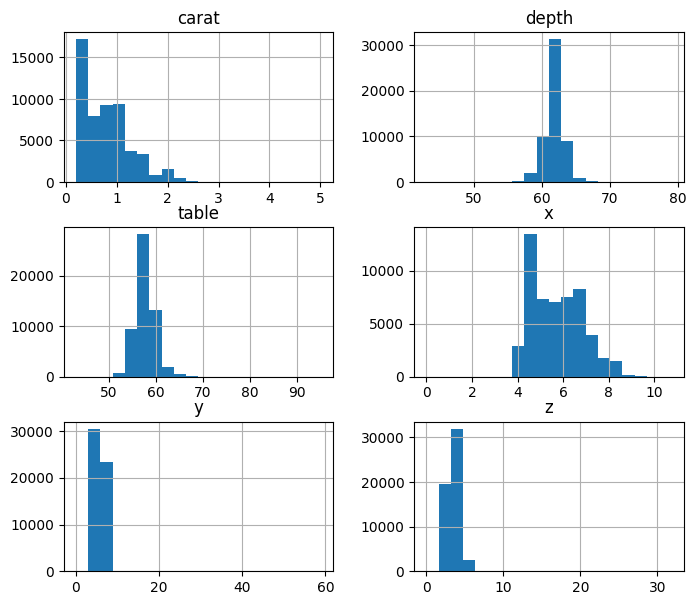

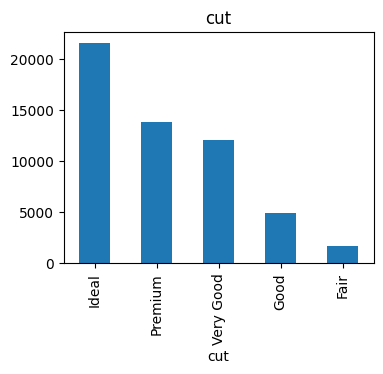

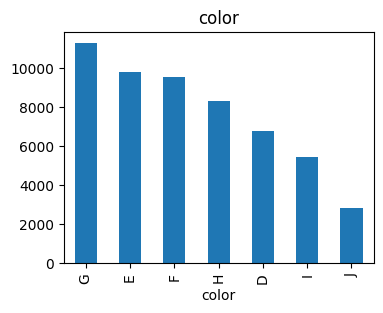

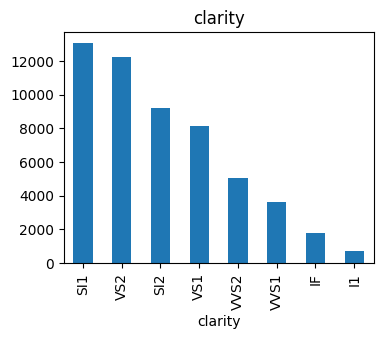

In [9]:
num_cols = df.select_dtypes(include=np.number).columns


cat_cols = df.select_dtypes(include=['object', 'category']).columns


df[num_cols.drop('price')].hist(bins=20, figsize=(8,7))


for col in cat_cols:
  plt.figure(figsize=(4,3))
  df[col].value_counts().plot(kind='bar')
  plt.title(col)


plt.show()

In [10]:
# create new column with numerical values
df['cut'] = df['cut'].replace({'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5})



# create new column with numerical values
df['color'] = df['color'].replace({'J': 1, 'I': 2, 'H': 3, 'G': 4, 'F': 5, 'E':6, 'D': 7})

df['clarity'] = df['clarity'].replace({'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8})

df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,5,6,2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,4,6,3,59.8,61.0,326,3.89,3.84,2.31
2,0.23,2,6,5,56.9,65.0,327,4.05,4.07,2.31
3,0.29,4,2,4,62.4,58.0,334,4.20,4.23,2.63
4,0.31,2,1,2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,5,7,3,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,2,7,3,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,3,7,3,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,4,3,2,61.0,58.0,2757,6.15,6.12,3.74


In [11]:
def print_skewness(df):
    # Select only the numerical columns
    num_cols = df.select_dtypes(include='number')
    # Compute the skewness for each column
    skew_vals = num_cols.apply(lambda x: x.skew())
    # Print the skewness for each column
    print(skew_vals)
  
print_skewness(df)

carat      1.116646
cut       -0.717180
color     -0.189366
clarity    0.551438
depth     -0.082294
table      0.796896
price      1.618395
x          0.378676
y          2.434167
z          1.522423
dtype: float64


In [12]:
from scipy.stats import skew
def sqrt_transform(df):
    # Select only the numerical columns
    num_cols = df.select_dtypes(include='number')
    # Compute the skewness for each column
    skew_vals = num_cols.apply(lambda x: skew(x))
    # Select the skewed columns
    skewed_cols = skew_vals[abs(skew_vals) > 1].index
    # Apply the square root transformation to the skewed columns
    df[skewed_cols] = np.sqrt(df[skewed_cols])
    return df

df = sqrt_transform(df)
print_skewness(df)

carat      0.548471
cut       -0.717180
color     -0.189366
clarity    0.551438
depth     -0.082294
table      0.796896
price      0.844396
x          0.378676
y          0.363648
z          0.013974
dtype: float64


In [13]:
df.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

In [14]:
x = df[['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']]
y = df[['price']]

In [15]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets (70-30 split)
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Split train set into train and validation sets (80-20 split)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, random_state=42)


In [16]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_val_scaled = sc.transform(x_val)
x_test_scaled = sc.transform(x_test)

In [17]:
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lasso = linear_model.Lasso()
print("Lasso regression score: ", np.round(np.mean(cross_val_score(lasso, x_train_scaled, y_train, cv = 5, scoring = 'neg_mean_squared_error')), 5))

ridge = linear_model.Ridge()
print("Ridge regression score: ", np.round(np.mean(cross_val_score(ridge, x_train_scaled, y_train, cv = 5, scoring = 'neg_mean_squared_error')), 5))

import xgboost
xgb_reg = xgboost.XGBRegressor()
np.mean(cross_val_score(xgb_reg, x_train_scaled, y_train, cv = 5, scoring = 'neg_mean_squared_error'))
print("XGBoost regression score: ", np.round(np.mean(cross_val_score(xgb_reg, x_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')), 5))

Lasso regression score:  -43.91491
Ridge regression score:  -37.15203
XGBoost regression score:  -9.5002


In [18]:
import tensorflow as tf
from tensorflow import keras  

red_neuronal = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(9,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

# Compile the model
red_neuronal.compile(optimizer='adam', loss='mse')

# Train the model with validation and record the training loss
history = red_neuronal.fit(x_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(x_val_scaled, y_val))



Epoch 1/100
944/944 [==============================] - 4s 3ms/step - loss: 424.6379 - val_loss: 55.5897
Epoch 2/100
944/944 [==============================] - 2s 3ms/step - loss: 31.8301 - val_loss: 34.9843
Epoch 3/100
944/944 [==============================] - 2s 2ms/step - loss: 22.4875 - val_loss: 29.8451
Epoch 4/100
944/944 [==============================] - 3s 3ms/step - loss: 19.1955 - val_loss: 28.3772
Epoch 5/100
944/944 [==============================] - 3s 3ms/step - loss: 17.1486 - val_loss: 28.7710
Epoch 6/100
944/944 [==============================] - 2s 3ms/step - loss: 15.9202 - val_loss: 27.2327
Epoch 7/100
944/944 [==============================] - 2s 2ms/step - loss: 15.1607 - val_loss: 26.8260
Epoch 8/100
944/944 [==============================] - 2s 2ms/step - loss: 14.7134 - val_loss: 26.2027
Epoch 9/100
944/944 [==============================] - 2s 3ms/step - loss: 14.2655 - val_loss: 26.7929
Epoch 10/100
944/944 [==============================] - 4s 4ms/step - lo

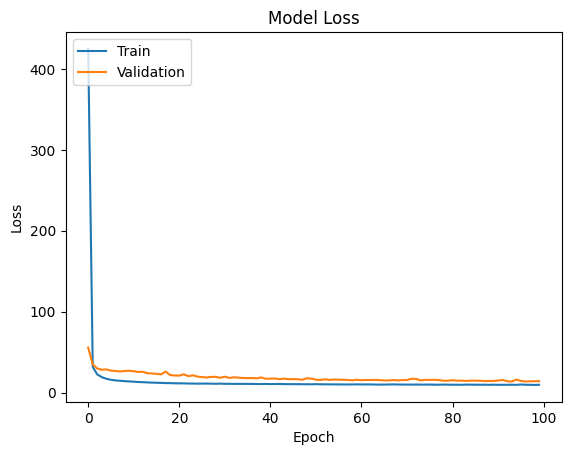

In [20]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Model Loss')
plt.legend(loc='upper left')

In [ ]:
lasso.fit(x_train_scaled, y_train)
ridge.fit(x_train_scaled, y_train)
xgb_reg.fit(x_train_scaled, y_train)

lasso_yhat  = lasso.predict(x_test_scaled)
ridge_yhat = ridge.predict(x_test_scaled)
xgb_yhat = xgb_reg.predict(x_test_scaled)

In [ ]:

from sklearn.metrics import mean_squared_error

print("Lasso regression accuracy: %.2f" % mean_squared_error(y_test, lasso_yhat) )
print("Ridge regression accuracy: %.2f" % mean_squared_error(y_test, ridge_yhat) )
print("XGBoost regression accuracy: %.2f" % mean_squared_error(y_test, xgb_yhat) )
print("Neural net regression accuracy: %.2f" % red_neuronal.evaluate(x_test_scaled, y_test))

Lasso regression accuracy: 42.67
Ridge regression accuracy: 36.22
XGBoost regression accuracy: 9.08
506/506 [==============================] - 1s 2ms/step - loss: 11.0433
Neural net regression accuracy: 11.04


## Optimizacion de hiperparametros

In [ ]:
!pip install neptune-client neptune-xgboost neptune-optuna

In [ ]:
import neptune.new as neptune
import neptune.new.integrations.optuna as optuna_utils

# Initialize Neptune
run = neptune.init_run(project="ivanv21/AI-Lab-School-Examen",
                   api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlN2NhNmY0YS00MjY3LTQ5MGUtOWY3OC1iM2VmNzZhMmQ2MjUifQ==")


In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.5, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'random_state': 42,
        'objective': 'reg:squarederror'
    }

    # Train and validate the model
    model = xgb.XGBRegressor(**params)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    mse = mean_squared_error(y_val, y_pred)

    # Log the hyperparameters and performance metric in Neptune
    run[f'trial_{trial.number}/params'] = params
    run[f'trial_{trial.number}/mse'] = mse

    return mse


In [ ]:
study = optuna.create_study(direction='minimize')
optuna_callback = optuna_utils.NeptuneCallback(run=run)

study.optimize(objective, n_trials=100, callbacks=[optuna_callback])


In [ ]:
best_params = study.best_params
best_mse = study.best_value

run['best_params'] = best_params
run['best_mse'] = best_mse

# Stop Neptune
run.stop()

## Final

In [25]:
params = {
    'colsample_bytree': 0.8974584024553048,
    'gamma': 6.836362566343923,
    'learning_rate': 0.019152508572159815,
    'max_depth': 8,
    'min_child_weight': 4.69150475424334,
    'n_estimators': 710,
    'reg_alpha': 0.6781257724089778,
    'reg_lambda': 0.24653591405367759,
    'subsample': 0.7537697435274283
}

best_model = xgboost.XGBRegressor(**params)

In [26]:
best_model.fit(x_train_scaled, y_train)

best_model_yhat = best_model.predict(x_test_scaled)

print("Optimized XGBoost regression accuracy: %.2f" % mean_squared_error(y_test, best_model_yhat) )



Optimized XGBoost regression accuracy: 8.39


In [27]:
best_model_yhat = best_model_yhat.ravel()
y_test = y_test.values.ravel()
print(y_test.shape)
print(best_model_yhat.shape)
print(best_model_yhat.ndim)
print(y_test.ndim)

(16182,)
(16182,)
1
1


In [28]:
results = pd.DataFrame({'Real Prices': y_test, 'Predicted Prices': best_model_yhat})

# Print out the dataframe
results

,Real Prices,Predicted Prices
0,23.643181,22.767719
1,46.914816,48.108173
2,35.185224,34.471786
3,36.110940,36.029766
4,83.072258,99.129440
...,...,...
16177,26.551836,28.155281
16178,72.649845,69.372307
16179,114.703967,113.332848
16180,54.405882,57.201157


In [29]:
import pickle

with open('modelo_examen_parte1.pkl', 'wb') as f:
    pickle.dump(best_model, f)



In [24]:
with open('modelo_examen_parte1.pkl', 'rb') as f:
    model = pickle.load(f)

In [25]:
y_test_series = pd.Series(y_test)
x_test = x_test.reset_index(drop=True)
y_test_series = y_test_series.reset_index(drop=True)
test_data = pd.concat([x_test, y_test_series], axis=1)
test_data

,carat,cut,color,clarity,depth,table,x,y,z,0
0,0.489898,5,4,7,62.1,56.0,3.97,2.000000,1.571623,23.643181
1,0.761577,3,5,6,60.0,57.0,5.44,2.328089,1.805547,46.914816
2,0.632456,5,6,6,62.1,55.0,4.76,2.177154,1.717556,35.185224
3,0.655744,4,6,6,60.8,57.0,4.92,2.211334,1.726268,36.110940
4,1.244990,5,6,2,62.3,55.0,7.44,2.714774,2.147091,83.072258
...,...,...,...,...,...,...,...,...,...,...
16177,0.640312,4,6,3,61.2,59.0,4.78,2.195450,1.714643,26.551836
16178,1.029563,5,3,3,63.0,55.0,6.49,2.537716,2.019901,72.649845
16179,1.228821,4,4,4,60.8,60.0,7.42,2.716616,2.121320,114.703967
16180,0.842615,2,5,6,58.9,61.0,5.80,2.428992,1.854724,54.405882
